# Импорт библиотек


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore') # игнорируем предуприждения

#### Загружаем данные

In [22]:
data = pd.read_excel("train.xlsx", parse_dates=["dt"], index_col="dt")
data.columns = ["price"]

#### Смотрим на данные

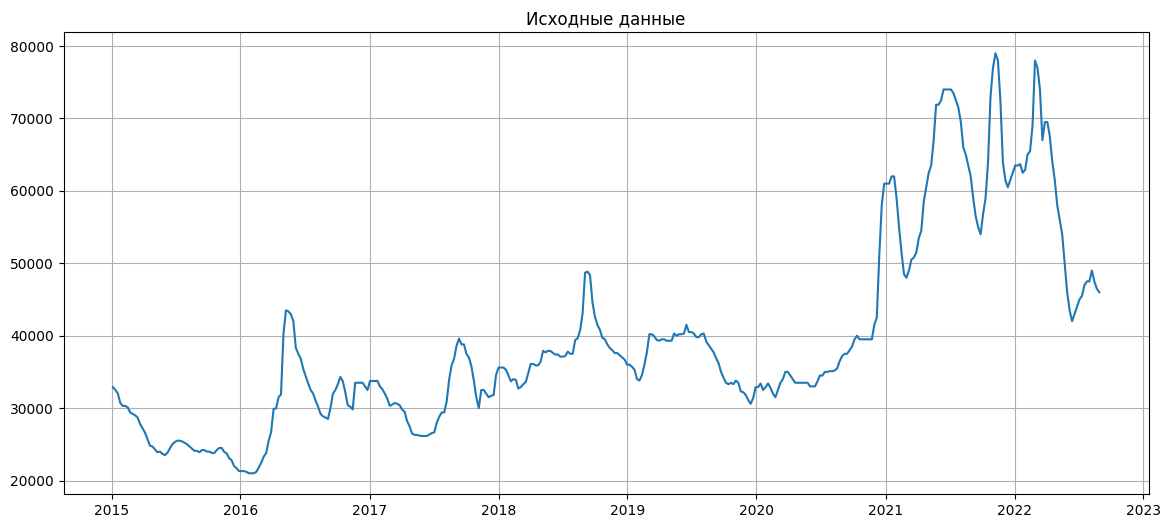

In [23]:
plt.figure(figsize=(14, 6))
plt.plot(data, label="Цена на арматуру")
plt.title("Исходные данные")
plt.grid()
plt.show()

Проверяем стационарность

In [24]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Критические значения:')
    for k, v in result[4].items():
        print(f'{k}: {v}')
    
check_stationarity(data['price'])

ADF Statistic: -1.9258699893713453
p-value: 0.3199906102569917
Критические значения:
1%: -3.4470566389664703
5%: -2.8689037160476016
10%: -2.570692663557422


#### Декомпозицыя убираем все вроде как ненужное 

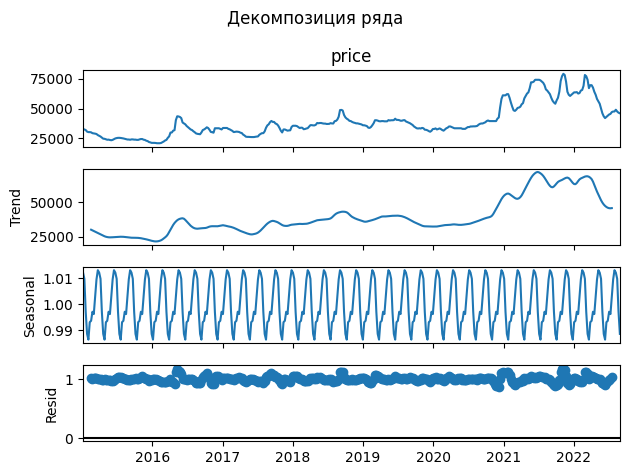

In [25]:
decomposition = seasonal_decompose(data['price'], model='multiplicative', period=12)
decomposition.plot()
plt.suptitle("Декомпозиция ряда")
plt.tight_layout()
plt.show()

#### Разделяем на тест и трэйн

In [26]:
train = data.iloc[:-30]
test = data.iloc[-30:]

# Работа с моделями

#### Создаем и обучаем модель SARIMA

In [27]:
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=0)
sarima_forecast = sarima_fit.forecast(steps=30)
sarima_r2 = r2_score(test, sarima_forecast)

#### теперь Prophet

In [28]:
prophet_data = train.reset_index().rename(columns={'dt':'ds', 'price':'y'})
prophet_model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=30, freq='W')
prophet_forecast = prophet_model.predict(future)
prophet_r2 = r2_score(test['price'], prophet_forecast.tail(30)['yhat'])


20:15:22 - cmdstanpy - INFO - Chain [1] start processing
20:15:22 - cmdstanpy - INFO - Chain [1] done processing


#### XGBoost Создание улутшение обучение

In [29]:
def create_features(df):
    features = df.copy()
# Создаем лаги
    for lag in [1, 2, 4, 8, 12]:
        features[f'lag_{lag}'] = features['price'].shift(lag)
# Скользящие статистики
    features['rolling_mean_4'] = features['price'].rolling(4).mean()
    features['rolling_std_12'] = features['price'].rolling(12).std()
# Дополнительные признаки
    features['month'] = features.index.month
    features['year'] = features.index.year
    return features.dropna()


#### Добавление признаков тест

In [30]:

train_feat = create_features(train.copy())
test_feat = create_features(test.copy())

required_features = ['lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_12', 
                   'rolling_mean_4', 'rolling_std_12',
                   'month', 'year']


X_train = train_feat[required_features]
y_train = train_feat['price']
X_test = test_feat[required_features]
y_test = test_feat['price']

#### Обучение

In [31]:
xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.01,
    random_state=42
)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

Прогназируем

In [32]:
xgb_forecast = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_forecast)

#### Сравнение моделей

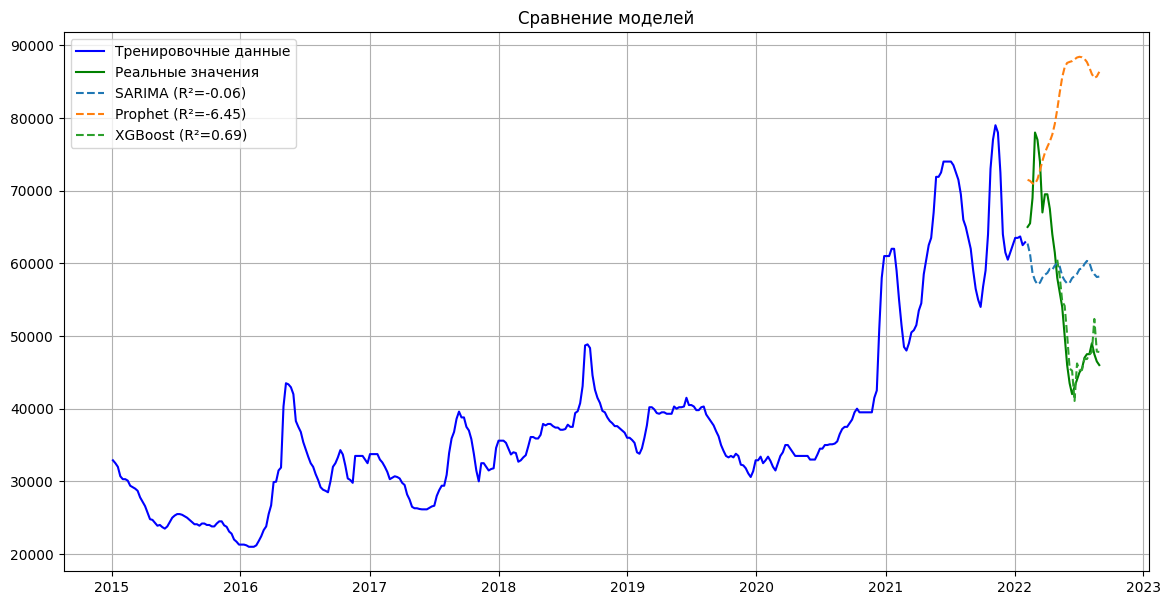

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['price'], label='Тренировочные данные', color='blue')
plt.plot(test.index, test['price'], label='Реальные значения', color='green')
plt.plot(test.index, sarima_forecast, label=f'SARIMA (R²={sarima_r2:.2f})', linestyle='--')
plt.plot(test.index, prophet_forecast.tail(30)['yhat'].values, label=f'Prophet (R²={prophet_r2:.2f})', linestyle='--')
plt.plot(test_feat.index, xgb_forecast, label=f'XGBoost (R²={xgb_r2:.2f})', linestyle='--')
plt.title('Сравнение моделей')
plt.legend()
plt.grid()
plt.show()

#### По метрике лутшая XGBoost

#### Выбор модели

In [34]:
best_model = max([('SARIMA', sarima_r2), ('Prophet', prophet_r2), ('XGBoost', xgb_r2)], key=lambda x: x[1])
print(f"\nЛучшая модель: {best_model[0]} с R² = {best_model[1]:.2f}")


Лучшая модель: XGBoost с R² = 0.69


# Прогноз на 30 недель

In [35]:
print("\nСтроим прогноз на 30 недель...")
if best_model[0] == 'SARIMA':
    final_model = SARIMAX(data, order=(1,1,1), seasonal_order=(1,1,1,12))
    final_fit = final_model.fit(disp=0)
    forecast = final_fit.forecast(steps=30)
elif best_model[0] == 'Prophet':
    prophet_final = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
    prophet_final.fit(data.reset_index().rename(columns={'dt':'ds', 'price':'y'}))
    future = prophet_final.make_future_dataframe(periods=30, freq='W')
    forecast = prophet_final.predict(future)['yhat'].tail(30).values
else:
# Для XGBoost создаем признаки на будующее
    last_date = data.index[-1]
    future_dates = pd.date_range(last_date, periods=30, freq='W')
    future_data = pd.DataFrame(index=future_dates)
    last_values = data.tail(12).copy()
    for i in range(30):
        temp_df = pd.concat([last_values, future_data.iloc[:i]], axis=0)
        
# Рассчитываем признаки
        for lag in [1, 2, 4, 8, 12]:
            future_data.loc[future_dates[i], f'lag_{lag}'] = temp_df['price'].shift(lag).iloc[-1]
        
        future_data.loc[future_dates[i], 'rolling_mean_4'] = temp_df['price'].rolling(4).mean().iloc[-1]
        future_data.loc[future_dates[i], 'rolling_std_12'] = temp_df['price'].rolling(12).std().iloc[-1]
        future_data.loc[future_dates[i], 'month'] = future_dates[i].month
        future_data.loc[future_dates[i], 'year'] = future_dates[i].year
    
# Прогнозируем
    forecast = xgb_model.predict(future_data[required_features])


Строим прогноз на 30 недель...


#### Смотрим на предсказание будующего

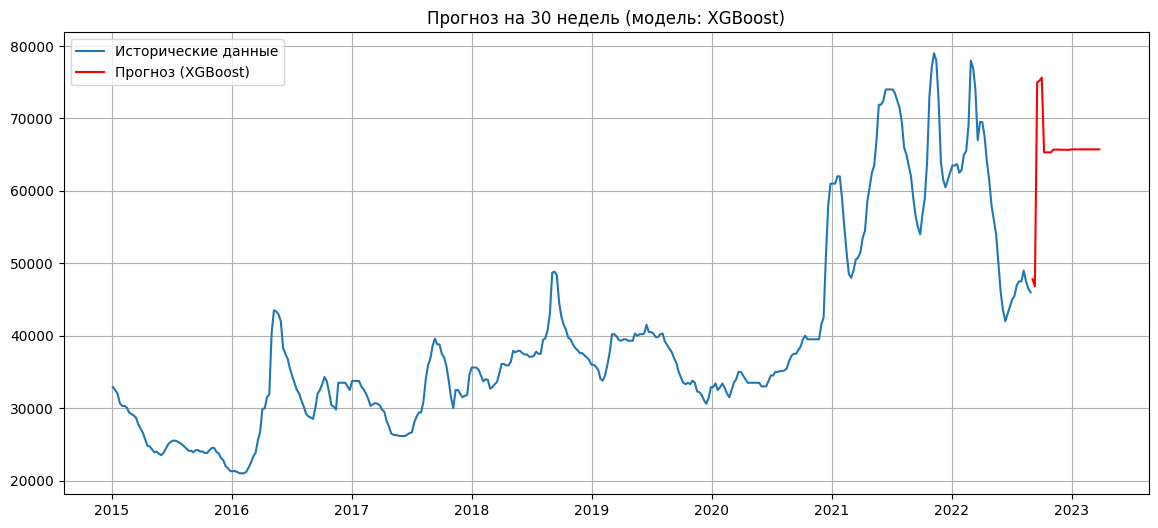

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['price'], label='Исторические данные')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='W'), forecast, 
         label=f'Прогноз ({best_model[0]})', color='red')
plt.title(f'Прогноз на 30 недель (модель: {best_model[0]})')
plt.legend()
plt.grid()
plt.show()